# Model Training

### 1.  Import Data and Required Packages

In [1]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

colorarr = ['#0592D0','#Cd7f32', '#E97451', '#Bdb76b', '#954535', '#C2b280', '#808000','#C2b280', '#E4d008', '#9acd32', '#Eedc82', '#E4d96f',
           '#32cd32','#39ff14','#00ff7f', '#008080', '#36454f', '#F88379', '#Ff4500', '#Ffb347', '#A94064', '#E75480', '#Ffb6c1', '#E5e4e2',
           '#Faf0e6', '#8c92ac', '#Dbd7d2','#A7a6ba', '#B38b6d']

### 2.  Import the CSV Data as Pandas DataFrame

In [2]:
df = pd.read_csv('D:/glob/fertilizer/Dataset.csv')

### 3. Show Top 5 Records

In [3]:
df.head()

,Temperature,Humidity,Rainfall,pH,N,P,K,Soil,Crop,Fertilizer
0,24.87,82.84,295.61,6.59,4.0,2.0,2.5,Clayey,rice,DAP and MOP
1,28.69,96.65,178.96,6.08,4.0,4.0,4.0,laterite,Coconut,Good NPK
2,20.27,81.64,270.44,5.01,4.0,4.0,2.0,silty clay,rice,MOP
3,25.07,95.02,192.90,5.55,2.0,2.1,3.5,sandy,Coconut,Urea and DAP
4,25.04,95.90,174.80,6.18,2.0,3.9,2.1,coastal,Coconut,Urea and MOP


In [4]:
from sklearn.preprocessing import LabelEncoder
soil_type_label_encoder = LabelEncoder()
df["Soil"] = soil_type_label_encoder.fit_transform(df["Soil"])

In [5]:
crop_type_label_encoder = LabelEncoder()
df["Crop"] = crop_type_label_encoder.fit_transform(df["Crop"])

In [6]:
fertilizer_type_label_encoder = LabelEncoder()
df["Fertilizer"] = fertilizer_type_label_encoder.fit_transform(df["Fertilizer"])

In [7]:
crop_dict = {}
for i in range(len(df["Crop"].unique())):
    crop_dict[i] = crop_type_label_encoder.inverse_transform([i])[0]
print(crop_dict)

soil_dict = {}
for i in range(len(df["Soil"].unique())):
    soil_dict[i] = soil_type_label_encoder.inverse_transform([i])[0]
print(soil_dict)

fertilizer_dict = {}
for i in range(len(df["Fertilizer"].unique())):
    fertilizer_dict[i] = fertilizer_type_label_encoder.inverse_transform([i])[0]
print(fertilizer_dict)

{0: 'Coconut', 1: 'rice'}
{0: 'Clayey', 1: 'alluvial', 2: 'clay loam', 3: 'coastal', 4: 'laterite', 5: 'sandy', 6: 'silty clay'}
{0: 'DAP', 1: 'DAP and MOP', 2: 'Good NPK', 3: 'MOP', 4: 'Urea ', 5: 'Urea and DAP', 6: 'Urea and MOP'}


### 4. Preparing X and Y variables

In [8]:
X = df.drop(columns=['Fertilizer'],axis=1)
X.head()

,Temperature,Humidity,Rainfall,pH,N,P,K,Soil,Crop
0,24.87,82.84,295.61,6.59,4.0,2.0,2.5,0,1
1,28.69,96.65,178.96,6.08,4.0,4.0,4.0,4,0
2,20.27,81.64,270.44,5.01,4.0,4.0,2.0,6,1
3,25.07,95.02,192.90,5.55,2.0,2.1,3.5,5,0
4,25.04,95.90,174.80,6.18,2.0,3.9,2.1,3,0


In [9]:
y = df['Fertilizer']

In [27]:
y

0      1
1      2
2      3
3      5
4      6
      ..
195    0
196    6
197    5
198    0
199    6
Name: Fertilizer, Length: 200, dtype: int32

In [11]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
# Select numeric and categorical features
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

# Define your transformers
numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

# Define your preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
         ("StandardScaler", numeric_transformer, num_features),        
    ]
)

In [29]:
df.head()

,Temperature,Humidity,Rainfall,pH,N,P,K,Soil,Crop,Fertilizer
0,24.87,82.84,295.61,6.59,4.0,2.0,2.5,0,1,1
1,28.69,96.65,178.96,6.08,4.0,4.0,4.0,4,0,2
2,20.27,81.64,270.44,5.01,4.0,4.0,2.0,6,1,3
3,25.07,95.02,192.90,5.55,2.0,2.1,3.5,5,0,5
4,25.04,95.90,174.80,6.18,2.0,3.9,2.1,3,0,6


In [13]:
X = preprocessor.fit_transform(X)

In [14]:
X.shape

(200, 9)

In [15]:
# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
X_train.shape, X_test.shape

((160, 9), (40, 9))

### 5. Create an Evaluate Function to give all metrics after model Training

In [16]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [17]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 0.6142
- Mean Absolute Error: 0.5385
- R2 Score: 0.9115
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1.1061
- Mean Absolute Error: 0.7521
- R2 Score: 0.7819


Lasso
Model performance for Training set
- Root Mean Squared Error: 1.3409
- Mean Absolute Error: 1.1169
- R2 Score: 0.5782
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1.6794
- Mean Absolute Error: 1.4302
- R2 Score: 0.4972


Ridge
Model performance for Training set
- Root Mean Squared Error: 0.6143
- Mean Absolute Error: 0.5381
- R2 Score: 0.9115
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1.1066
- Mean Absolute Error: 0.7545
- R2 Score: 0.7817


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 0.4894
- Mean Absolute Error: 0.2800
- R2 Score: 0.9438
-----------------------

### 6. Results

In [18]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
4,Decision Tree,0.888579
6,AdaBoost Regressor,0.888579
5,Random Forest Regressor,0.888579
0,Linear Regression,0.781902
2,Ridge,0.781707
3,K-Neighbors Regressor,0.740613
1,Lasso,0.497211


###  7.  Decision Tree Accuracy

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of the model is %.2f" % (accuracy*100))

Accuracy of the model is 97.50


### 8.  Plot y_pred and y_test

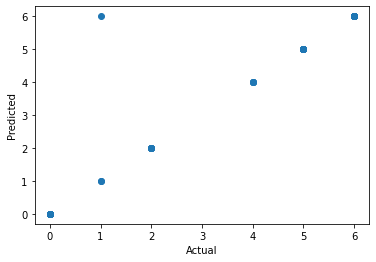

In [20]:
plt.scatter(y_test,y_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted');

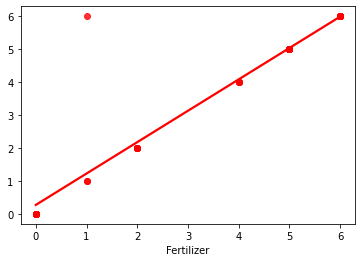

In [21]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red');

### 9.  Difference between Actual and Predicted Values

In [22]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
18,5,5,0
170,2,2,0
107,0,0,0
98,0,0,0
177,0,0,0
182,0,0,0
5,4,4,0
146,6,6,0
12,2,2,0
152,2,2,0


In [25]:
df

,Temperature,Humidity,Rainfall,pH,N,P,K,Soil,Crop,Fertilizer
0,24.87,82.84,295.61,6.59,4.0,2.0,2.5,0,1,1
1,28.69,96.65,178.96,6.08,4.0,4.0,4.0,4,0,2
2,20.27,81.64,270.44,5.01,4.0,4.0,2.0,6,1,3
3,25.07,95.02,192.90,5.55,2.0,2.1,3.5,5,0,5
4,25.04,95.90,174.80,6.18,2.0,3.9,2.1,3,0,6
...,...,...,...,...,...,...,...,...,...,...
195,23.58,83.59,291.30,5.85,4.0,2.0,3.0,6,1,0
196,25.66,83.47,217.38,7.12,2.0,3.9,2.1,0,1,6
197,24.17,83.73,257.03,5.58,2.0,2.1,3.5,6,1,5
198,26.23,83.84,286.51,5.54,4.2,2.3,3.2,6,1,0
